# Week 12 Homework (10)

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from sklearn.metrics import confusion_matrix

## Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)
---

## 1. Gaussian Processes and Stochastic Processes

A **stochastic process** is a collection of random variables indexed by a parameter (often time or space). It is typically denoted as

$$
\{X_t : t \in T\},
$$

where:
- **\\(T\\)** is the index set (e.g., time, space, or any other domain),
- **\\(X_t\\)** is a random variable corresponding to the index \\(t\\).

The key idea is that for any finite collection of indices \(t_1, t_2, \dots, t_n \in T\), the random vector

$$
\mathbf{X} = \big(X_{t_1}, X_{t_2}, \dots, X_{t_n}\big)
$$

has a joint probability distribution. The entire process is characterized by these finite-dimensional distributions. Stochastic processes are widely used in fields such as physics, finance, and engineering to model systems that evolve in a probabilistic manner.

---

### Gaussian Processes (GPs)

A **Gaussian Process (GP)** is a special type of stochastic process where any finite collection of random variables has a joint **multivariate Gaussian (normal)** distribution. In other words, if

$$
f(x) \sim \mathcal{GP}\big(m(x), k(x,x')\big),
$$

then for any finite set of input points \(x_1, x_2, \dots, x_n\), the corresponding outputs

$$
\big(f(x_1), f(x_2), \dots, f(x_n)\big)
$$

are jointly Gaussian distributed:

$$
\begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_n)
\end{pmatrix}
\sim \mathcal{N}\left(
\begin{pmatrix}
m(x_1) \\
m(x_2) \\
\vdots \\
m(x_n)
\end{pmatrix},
\begin{pmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) & \cdots & k(x_2, x_n) \\
\vdots      & \vdots      & \ddots & \vdots      \\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{pmatrix}
\right).
$$

Here, the two defining components are:

- **Mean Function:**  
  $$ m(x) = \mathbb{E}[f(x)], $$
  which describes the average behavior of the process.

- **Covariance Function (Kernel):**  
  $$ k(x,x') = \text{Cov}(f(x), f(x')), $$
  which encodes the similarity or correlation between the function values at different points \\(x\\) and \\(x'\\).

#### Why Use Gaussian Processes?
- **Non-Parametric Flexibility:** GPs do not assume a fixed functional form for the underlying function; instead, they define a distribution over functions.
- **Uncertainty Quantification:** They provide not only predictions but also a measure of uncertainty associated with those predictions.
- **Kernel Customization:** By choosing different kernels \\(k(x,x')\\), one can encode various properties like smoothness, periodicity, or linearity.

---

### Summary

- **Stochastic Process:** A family of random variables \\(\{X_t : t \in T\}\\) where every finite collection \\((X_{t_1}, \dots, X_{t_n})\\) has a joint probability distribution. This framework is used to model systems evolving under uncertainty.
- **Gaussian Process:** A specific type of stochastic process where every finite subset is jointly Gaussian. It is fully characterized by a mean function \\(m(x)\\) and a covariance function \\(k(x,x')\\), making it a powerful tool for regression, classification, and other inference tasks in a probabilistic framework.


## 2. Variational Inference and the Evidence Lower Bound (ELBO)

Variational inference (VI) is a method in Bayesian statistics that approximates an intractable posterior distribution with a simpler, tractable family of distributions by turning the inference problem into an optimization problem.

### The Bayesian Inference Problem

Given observed data \\(x\\) and latent variables \\(z\\), the posterior distribution is given by Bayes’ rule:

$$
p(z|x) = \frac{p(x, z)}{p(x)},
$$

where the marginal likelihood (or evidence) is

$$
p(x) = \int p(x,z)\,dz.
$$

In many complex models, directly computing \(p(x)\) is intractable due to the high-dimensional integral.

### Introducing a Variational Distribution

To sidestep this intractability, we introduce a variational distribution \\(q(z)\\) from a simpler family, which serves as an approximation to the true posterior \\(p(z|x)\\). Our goal is to find the \\(q(z)\\) that is closest to \\(p(z|x)\\) by minimizing the Kullback-Leibler (KL) divergence:

$$
\text{KL}\big(q(z) \parallel p(z|x)\big) = \mathbb{E}_{q(z)}\left[\log \frac{q(z)}{p(z|x)}\right].
$$

### Derivation of the ELBO

Direct minimization of the KL divergence is challenging because \\(p(z|x)\\) involves the intractable evidence \\(p(x)\\). Instead, we can rewrite the log evidence by introducing \\(q(z)\\):

$$
\log p(x) = \mathbb{E}_{q(z)}\left[\log p(x)\right] = \mathbb{E}_{q(z)}\left[\log \frac{p(x,z)}{p(z|x)}\right].
$$

Rearrange the terms to obtain:

$$
\log p(x) = \underbrace{\mathbb{E}_{q(z)}\left[\log \frac{p(x,z)}{q(z)}\right]}_{\mathcal{L}(q)} + \underbrace{\mathbb{E}_{q(z)}\left[\log \frac{q(z)}{p(z|x)}\right]}_{\text{KL}\big(q(z) \parallel p(z|x)\big)}.
$$

Thus, we have

$$
\log p(x) = \mathcal{L}(q) + \text{KL}\big(q(z) \parallel p(z|x)\big).
$$

Since the KL divergence is always non-negative, the term

$$
\mathcal{L}(q) = \mathbb{E}_{q(z)}\left[\log \frac{p(x,z)}{q(z)}\right]
$$

serves as a **lower bound** on the log evidence \(\log p(x)\); this is the **Evidence Lower Bound (ELBO)**:

$$
\log p(x) \geq \mathcal{L}(q).
$$

### Components of the ELBO

Breaking down the ELBO:

- **Joint Likelihood Term:**  
  \\(\mathbb{E}_{q(z)}\left[\log p(x,z)\right]\\) encourages the variational distribution \\(q(z)\\) to explain the observed data well under the model.

- **Entropy Term:**  
  \\(-\mathbb{E}_{q(z)}\left[\log q(z)\right]\\) represents the entropy of \\(q(z)\\), promoting a distribution that is not overly concentrated.

Thus, the ELBO can also be written as:

$$
\mathcal{L}(q) = \underbrace{\mathbb{E}_{q(z)}\left[\log p(x,z)\right]}_{\text{Expected joint log-likelihood}} + \underbrace{H\big(q(z)\big)}_{\text{Entropy of } q(z)}.
$$

## Optimization Perspective

The goal in variational inference is to find the variational distribution \\(q^*(z)\\) that maximizes the ELBO:

$$
q^*(z) = \underset{q \in \mathcal{Q}}{\operatorname{argmax}}\, \mathcal{L}(q).
$$

Maximizing the ELBO is equivalent to minimizing the KL divergence between \(q(z)\) and the true posterior \(p(z|x)\):

$$
\min_{q \in \mathcal{Q}} \text{KL}\big(q(z) \parallel p(z|x)\big) \quad \Longleftrightarrow \quad \max_{q \in \mathcal{Q}} \mathcal{L}(q).
$$

### Summary

- **Variational Inference:** An approximate inference technique that replaces an intractable posterior \\(p(z|x)\\) with a simpler variational distribution \\(q(z)\\).
- **ELBO:** Defined as

  $$
  \mathcal{L}(q) = \mathbb{E}_{q(z)}\left[\log \frac{p(x,z)}{q(z)}\right],
  $$

  it provides a lower bound on the log evidence \\(\log p(x)\\).
- **Optimization Objective:** Maximizing the ELBO minimizes the KL divergence between \\(q(z)\\) and \\(p(z|x)\\), thereby yielding the best approximation within the chosen family.

This framework converts the complex problem of Bayesian inference into a more manageable optimization problem, making it a powerful tool in many machine learning applications.


## Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

---

https://www.pymc.io/projects/examples/en/latest/statistical_rethinking_lectures/16-Gaussian_Processes.html

## Gaussian Process Regression on Daily Temperature Data

In this notebook we demonstrate how to use Gaussian Processes (GPs) with PyMC to model daily temperature variations over one year. The data are synthetic but are generated to mimic realistic seasonal temperature trends. We use a periodic covariance function to capture the inherent seasonality in temperature measurements.


In [28]:
# For reproducibility
np.random.seed(42)

### 1. Data Generation

We simulate daily temperature data for one year (365 days). The temperatures are generated using a sinusoidal function (to capture seasonality) plus some Gaussian noise. In this example, the “true” temperature follows the function:

\\[
\text{temperature}(d) = 10 + 15 \sin\left(\frac{2\pi d}{365}\right) + \epsilon,
\\]

where \\(\epsilon\\) is Gaussian noise.


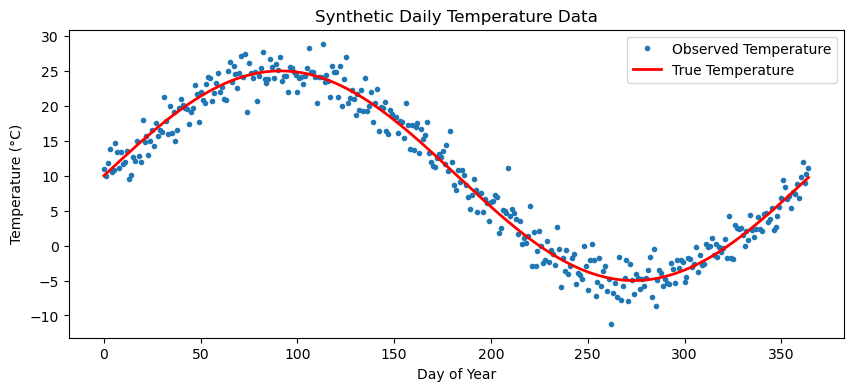

In [29]:
# Generate synthetic daily temperature data
days = np.arange(365)  # Days 0 to 364
true_temperature = 10 + 15 * np.sin(2 * np.pi * days / 365)
noise = np.random.normal(0, 2.0, size=days.shape)  # Gaussian noise with std dev 2
observed_temperature = true_temperature + noise

# Reshape days for GP (n_samples, n_features)
X = days.reshape(-1, 1)
y = observed_temperature

# Visualize the generated data
plt.figure(figsize=(10, 4))
plt.plot(days, y, 'o', markersize=3, label="Observed Temperature")
plt.plot(days, true_temperature, lw=2, color='red', label="True Temperature")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.title("Synthetic Daily Temperature Data")
plt.legend()
plt.show()

### 2. Defining the Gaussian Process Model

We build a Bayesian GP regression model using PyMC. To capture the seasonality, we use a **periodic covariance function**. In our model we place priors on the length scale and the overall noise scale. The GP is defined as a latent function with a periodic covariance, and observations are modeled with Gaussian noise.


In [36]:
with pm.Model() as gp_model:
    # Priors for the hyperparameters
    ls = pm.Gamma("ls", alpha=2, beta=1)  # Length scale
    period = pm.ConstantData("period", 365)  # Known period (1 year)
    cov_amp = pm.HalfNormal("cov_amp", sigma=5)  # Covariance amplitude
    
    # Define a periodic covariance function with increased jitter
    jitter = 1e-3  # Increased jitter to improve numerical stability
    cov = cov_amp**2 * pm.gp.cov.Periodic(1, ls=ls, period=period) + pm.gp.cov.WhiteNoise(jitter)
    
    # Noise standard deviation for the observations
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    # Define the Gaussian Process latent function
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X)
    
    # Likelihood (observations modeled with Gaussian noise)
    y_obs = pm.Normal("y_obs", mu=f, sigma=sigma, observed=y)

### 3. Fitting the Model using Variational Inference (ADVI)

We now fit the GP model using Automatic Differentiation Variational Inference (ADVI). The variational approximation provides an efficient way to estimate the posterior over the GP hyperparameters and the latent function.


In [37]:
with gp_model:
    # Run ADVI for a sufficient number of iterations
    approx = pm.fit(n=3000, method="advi")
    trace = approx.sample(1000)

Finished [100%]: Average Loss = 1,777.2


### 4. Posterior Predictive Inference

We now generate predictions over a fine grid of days to visualize the GP regression. Using the trained GP we compute the predictive mean and uncertainty bands (credible intervals) for the temperature across the year.

In [39]:
# Create a grid for prediction (fine resolution)
X_new = np.linspace(0, 364, 365).reshape(-1, 1)

with gp_model:
    # Compute the latent function at the new grid points
    f_pred = gp.conditional("f_pred", X_new)
    # Draw posterior predictive samples for f_pred
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], random_seed=42)
    
# Extract the samples from the InferenceData object:
f_pred_samples = pred_samples.posterior_predictive["f_pred"].values
# If necessary, reshape or combine chains/draws appropriately:
f_pred_samples = f_pred_samples.reshape(-1, X_new.shape[0])

# Compute predictive mean and 95% credible intervals
f_pred_mean = np.mean(f_pred_samples, axis=0)
f_pred_lower = np.percentile(f_pred_samples, 2.5, axis=0)
f_pred_upper = np.percentile(f_pred_samples, 97.5, axis=0)

### 5. Visualization of the GP Regression

We now plot:
- The observed temperature data.
- The GP predictive mean.
- The 95% credible interval that quantifies the uncertainty of our predictions.

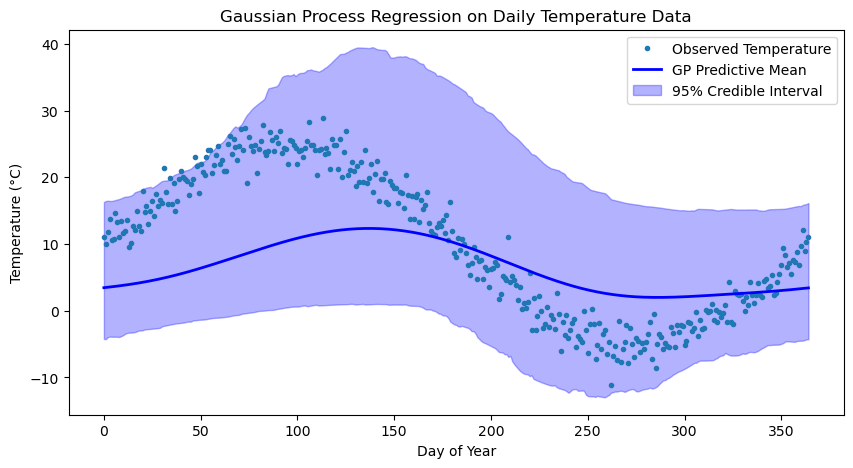

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(days, y, "o", markersize=3, label="Observed Temperature")
plt.plot(X_new.flatten(), f_pred_mean, lw=2, color="blue", label="GP Predictive Mean")
plt.fill_between(X_new.flatten(), f_pred_lower, f_pred_upper, color="blue", alpha=0.3, label="95% Credible Interval")
plt.xlabel("Day of Year")
plt.ylabel("Temperature (°C)")
plt.title("Gaussian Process Regression on Daily Temperature Data")
plt.legend()
plt.show()

### 6. Conclusion

In this demonstration we used PyMC to build a Gaussian Process regression model on synthetic daily temperature data. By employing a periodic covariance function, we were able to capture the seasonal variation in the data. The GP framework not only provides point estimates (predictive mean) but also quantifies uncertainty (credible intervals) in its predictions. This approach can be extended to real-world time series data and further refined with more complex covariance structures.


## Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

---

https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html 

## Bayesian Neural Network with ADVI on the Iris Dataset

This notebook demonstrates how to build and fit a Bayesian neural network using PyMC and Automatic Differentiation Variational Inference (ADVI). Unlike the original regression examples, here we tackle a classification problem using the Iris dataset. We define a simple feed-forward network with one hidden layer, place priors on all weights and biases, and then use ADVI to approximate the posterior over the network parameters.

In [3]:
import numpy as np
import pymc as pm
import aesara.tensor as at
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

### 1. Data Loading and Preprocessing

We load the Iris dataset, split it into training and test sets, and then standardize the features. The Iris dataset has 150 samples with 4 features each and 3 classes.

In [4]:
# Load the Iris dataset
data = load_iris()
X = data.data
y = data.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2. Defining the Bayesian Neural Network Model

In this section we define a Bayesian neural network with one hidden layer:
- **Input layer:** 4 features.
- **Hidden layer:** 10 neurons with a tanh activation function.
- **Output layer:** 3 neurons corresponding to the 3 Iris classes; we use a softmax transformation to obtain probabilities.

We place standard normal priors on all weights and biases.

In [5]:
# Define model dimensions
n_hidden = 10
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_train))

# Build the PyMC model
with pm.Model() as neural_net:
    # Priors for the weights and biases of the hidden layer
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1, shape=(n_features, n_hidden))
    biases_1 = pm.Normal("b_1", mu=0, sigma=1, shape=(n_hidden,))
    
    # Priors for the weights and biases of the output layer
    weights_2 = pm.Normal("w_2", mu=0, sigma=1, shape=(n_hidden, n_classes))
    biases_2 = pm.Normal("b_2", mu=0, sigma=1, shape=(n_classes,))
    
    # Forward pass: compute activations for the hidden layer using tanh
    act_1 = pm.math.tanh(pm.math.dot(X_train_scaled, weights_in_1) + biases_1)
    # Compute the logits for the output layer
    logits = pm.math.dot(act_1, weights_2) + biases_2
    
    # Likelihood using the categorical (multinomial) distribution with softmax probabilities
    out = pm.Categorical("out", p=pm.math.softmax(logits), observed=y_train)

### 3. Fitting the Model using ADVI

We now perform variational inference using ADVI to approximate the posterior distribution of the neural network's weights and biases. The ADVI fitting process returns an approximation that we sample to generate our trace.


In [6]:
with neural_net:
    # Fit the model using ADVI (increase n for more accurate approximation if needed)
    approx = pm.fit(n=20000, method='advi')
    trace = approx.sample(1000)

/opt/conda/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


Finished [100%]: Average Loss = nan


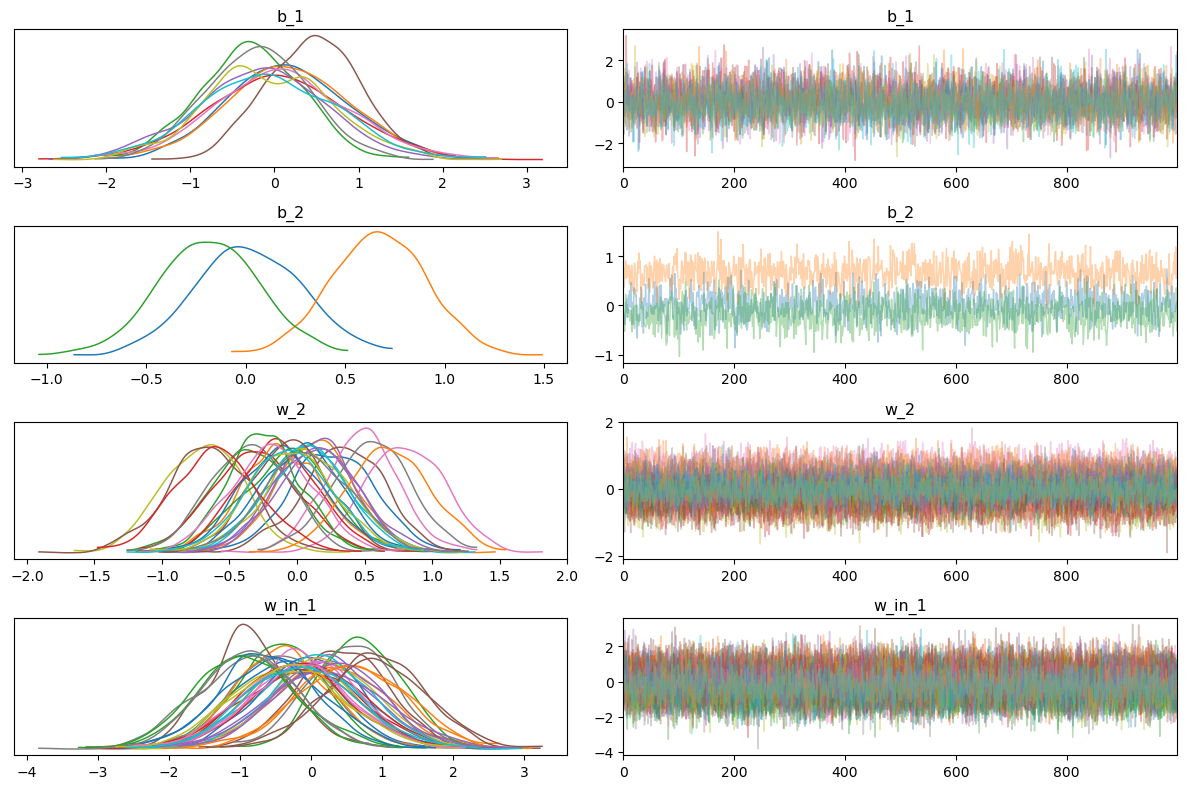

In [13]:
az.plot_trace(trace);
plt.tight_layout()

### 4. Posterior Predictive Inference on the Test Set

We define a helper function to compute predictive probabilities on the test set by passing the data through the network for each sample of the posterior weights. The final prediction is obtained by averaging the softmax outputs over the posterior samples.


In [25]:
def predict_proba_inference_data(X, trace, n_features, n_hidden, n_classes):
    # Extract samples from the InferenceData object and combine chains
    w_in_1_samples = trace.posterior['w_in_1'].values.reshape(-1, n_features, n_hidden)
    b_1_samples    = trace.posterior['b_1'].values.reshape(-1, n_hidden)
    w_2_samples    = trace.posterior['w_2'].values.reshape(-1, n_hidden, n_classes)
    b_2_samples    = trace.posterior['b_2'].values.reshape(-1, n_classes)
    
    preds = []
    # Iterate over all samples
    for W1, b1, W2, b2 in zip(w_in_1_samples, b_1_samples, w_2_samples, b_2_samples):
        # Compute hidden layer activation using tanh
        act_1 = np.tanh(np.dot(X, W1) + b1)
        # Compute logits for the output layer
        logits = np.dot(act_1, W2) + b2
        # Apply softmax to obtain probabilities
        exp_logits = np.exp(logits)
        pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        preds.append(pred)
    preds = np.array(preds)
    # Return the mean probability across all posterior samples
    return preds.mean(axis=0)

# Use the new prediction function
pred_probs = predict_proba_inference_data(X_test_scaled, trace, n_features, n_hidden, n_classes)
pred_classes = np.argmax(pred_probs, axis=1)

# Evaluate the model's performance
acc = accuracy_score(y_test, pred_classes)
print("Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, pred_classes))

Test Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.78      0.88         9
           2       0.85      1.00      0.92        11

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



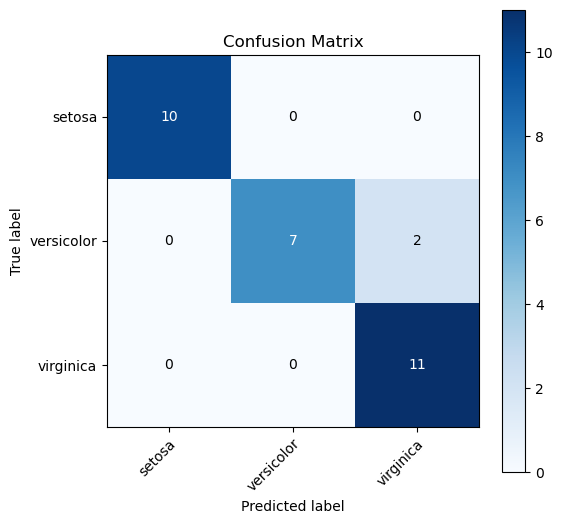

In [26]:
# Compute the confusion matrix using true labels and predicted classes
cm = confusion_matrix(y_test, pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = data.target_names if hasattr(data, 'target_names') else np.arange(n_classes)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the count
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.show()

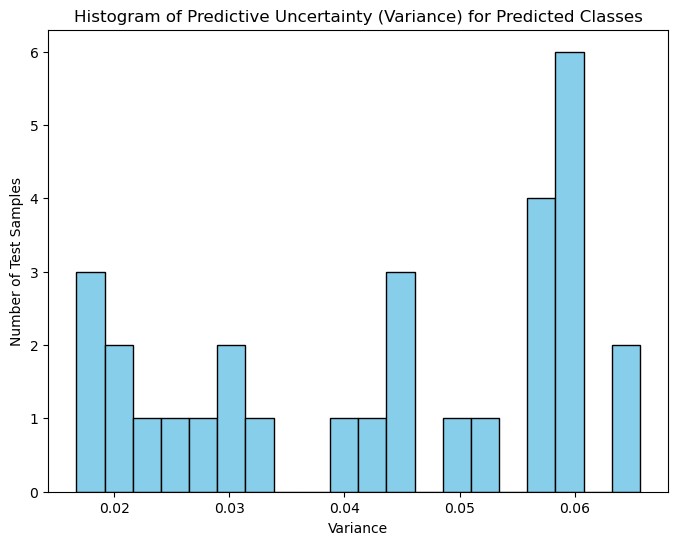

In [27]:
def predict_proba_samples(X, trace, n_features, n_hidden, n_classes):
    # Extract samples from the InferenceData object and combine chains
    w_in_1_samples = trace.posterior['w_in_1'].values.reshape(-1, n_features, n_hidden)
    b_1_samples    = trace.posterior['b_1'].values.reshape(-1, n_hidden)
    w_2_samples    = trace.posterior['w_2'].values.reshape(-1, n_hidden, n_classes)
    b_2_samples    = trace.posterior['b_2'].values.reshape(-1, n_classes)
    
    preds = []
    # Iterate over each posterior sample
    for W1, b1, W2, b2 in zip(w_in_1_samples, b_1_samples, w_2_samples, b_2_samples):
        # Compute the hidden layer activation using tanh
        act_1 = np.tanh(np.dot(X, W1) + b1)
        # Compute the logits for the output layer
        logits = np.dot(act_1, W2) + b2
        # Apply softmax to obtain probabilities
        exp_logits = np.exp(logits)
        pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        preds.append(pred)
    return np.array(preds)

# Obtain predictions from each posterior sample for the test set
preds_samples = predict_proba_samples(X_test_scaled, trace, n_features, n_hidden, n_classes)

# Compute variance of the predicted probabilities across posterior samples
variance = np.var(preds_samples, axis=0)

# For each test instance, take the variance corresponding to the predicted class probability
pred_class_variance = variance[np.arange(len(pred_classes)), pred_classes]

# Plot a histogram of the predictive uncertainty (variance) for the predicted classes
plt.figure(figsize=(8,6))
plt.hist(pred_class_variance, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Predictive Uncertainty (Variance) for Predicted Classes")
plt.xlabel("Variance")
plt.ylabel("Number of Test Samples")
plt.show()


### 5. Conclusion

In this demonstration we built a Bayesian neural network classifier using PyMC on the Iris dataset. By using ADVI for variational inference, we approximated the posterior distribution over the network weights, thereby quantifying uncertainty in our predictions. This approach not only provides a point estimate for predictions but also a measure of uncertainty—making it useful for applications where uncertainty quantification is important.